## Lab 4: Assessed
# Vector spaces and linear transforms

### Notes
It is recommended to keep the lecture notes open while doing this lab exercise. Note that this lab involves a significant amount of reading, but limited problem solving. Read through this lab *carefully* and work through the examples before attempting the tasks.

### References
If you are stuck, the following resources are very helpful:

* [NumPy cheatsheet](https://github.com/juliangaal/python-cheat-sheet/blob/master/NumPy/NumPy.md)
* [NumPy API reference](https://docs.scipy.org/doc/numpy-1.13.0/reference/)
* [NumPy user guide](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.html)




## Purpose of this lab
This lab should help you:
* understand how data can be represented as points in vector space
* understand the effect of different vector norms
* apply the inner product to compute the angle between vectors
* apply linear transforms to vectors

In [108]:
# Standard imports
# Make sure you run this cell!
# NumPy
import numpy as np  
import binascii

# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

# custom utils
from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import jhwutils.tick as tick

def case_crc(s):
    return binascii.crc32(bytes(s.lower(), 'ascii'))

print("Everything imported OK")

Everything imported OK


## Guidance
You will need to understand the following functions well to complete this lab:
You will need to understand the following functions well to complete this lab:
* [`np.argmin()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html) [Unit 1]
* [`np.argsort()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argsort.html) [Unit 1]
* [`np.linalg.norm()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html) [Unit 4]
* [`np.linalg.pinv()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.pinv.html) [Unit 5]
* [`np.linalg.eig()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.eig.html) [Unit 5]
* [`np.cov()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.cov.html) [Unit 4]

## Whisky: Representing and comparing vectors

Whisky distillation is a major industry in Scotland. 

<img src="imgs/stills.jpg"> <br><br>*[[Image](https://flickr.com/photos/sashafatcat/518104633 "stills") by [sashafatcat](https://flickr.com/people/sashafatcat) shared [CC BY](https://creativecommons.org/licenses/by/2.0/)]*

The dataset in `data/whisky.csv` is data from a number of whisky distilleries. For each distillery, there are a set of subjective judgements about the flavour characteristics of their production. The data comes from [this Strathclyde University research project](https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html).

Each distillery has been judged on twelve flavour indicators (like "smokiness" or "sweetness"), and they have been assigned values from 0-4 indicating the strength of that category, judged by an expert whisky drinker. These can be seen as 12D vectors, one vector per distillery. **Every distillery is represented as a point in twelve dimensional vector space.**

We also have a 2D array of the geographical locations of each distillery.

The code below loads the data into a NumPy array `whisky`.

## Loading the data

In [109]:
## It is not necessary to understand this code to complete
# the exercise. We don't cover pandas in DF(H)
import pandas as pd
whisky_df = pd.read_csv("data/whiskies.txt")
whisky_df = whisky_df.sort_values(by='Distillery')
# extract the column and row names
distilleries= np.array(whisky_df["Distillery"])

columns = {name.lower():index for index,name in enumerate(whisky_df.columns[2:-3])}

# split apart the data frame and form numpy arrays
locations = np.array(whisky_df.iloc[:,-2:])
whisky = np.array(whisky_df.iloc[:,2:-3])

# fix wine column
columns['wine'] = columns['winey']
del columns['winey']
# force tie breaks 
np.random.seed(2018)
whisky = whisky + np.random.normal(0,0.1,whisky.shape)

## Viewing the data

We can see this whole dataset as a heatmap:

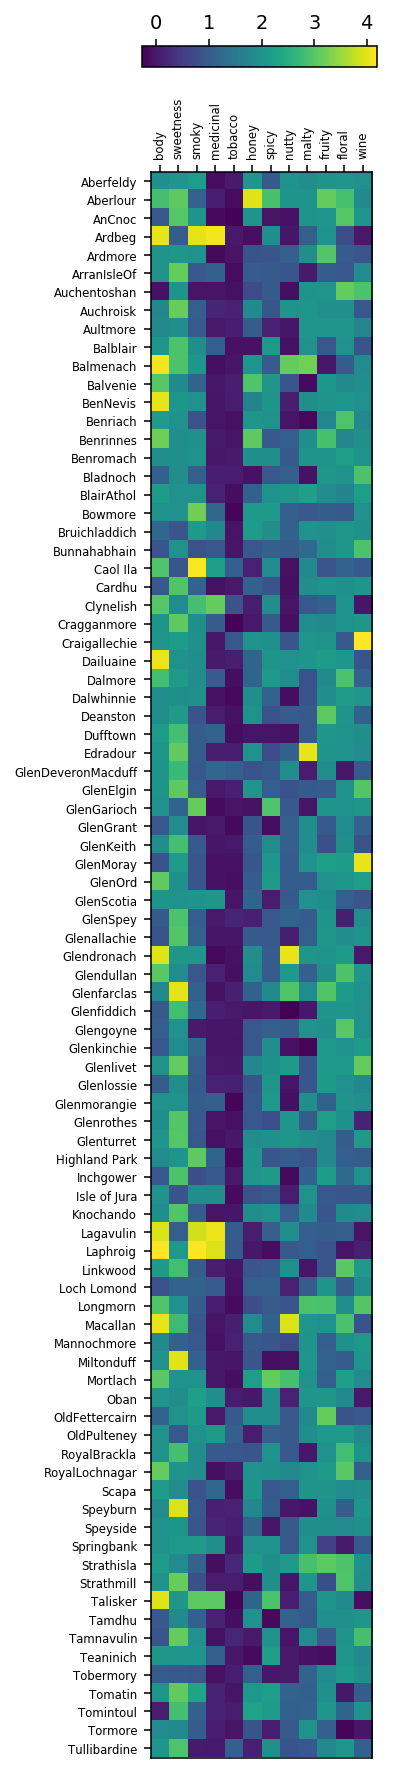

In [110]:
# show a plot of the whisky data
fig = plt.figure(figsize=(6,15))
ax = fig.add_subplot(1,1,1)

# image plot
img = ax.imshow(whisky)
ax.set_yticks(np.arange(len(distilleries)))
ax.set_yticklabels(distilleries, rotation="horizontal", fontsize=6)

# put the x axis at the top
ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation="vertical", fontsize=6)

# some horrific colorbar hackery to put in the right place
# don't worry about this bit!
cbaxes = fig.add_axes([0.37, 0.93, 0.28, 0.01])  
fig.colorbar(img, orientation='horizontal',  cax=cbaxes, ticks=np.arange(5))
cbaxes.xaxis.tick_top()

### Available data
You now have these variables:

* `whisky` an  86x12 array of taste judgements, one row for each of the 86 distilleries
* `distilleries` is a list of 86 distillery names
* `columns` is a mapping of feature names to column indices.
* `locations` is an 86x2 matrix of positions of each distillery in [OS grid reference format](https://www.gridreferencefinder.com/) in the same order as `whisky`

For example:

In [111]:
print(whisky[distilleries.searchsorted('Glenfiddich'), columns['smoky']])

1.2551637969677651


will tell you how "smoky" Glenfiddich was rated.

In [112]:
print(distilleries[8])

Aultmore


will tell you the 9th distillery in the dataset is `Aultmore`.

In [113]:
print(locations[distilleries.searchsorted('Glengoyne')])

[252810 682750]


will tell you where to find the Glengoyne distillery in UK OS grid units (you can almost see it out of the BO720 window if you look northwest). 

## A: Norms, interpolation and statistics
We will see some simple things we can do with this dataset. 


We can compute distances in **flavour space** between distilleries.

For example, we can compute the distance between the `Glenlivet` distillery and every other distillery *in terms of flavour, not physical distance*. The result will be a 1D vector of 86 distances. 

Remember: distance of $\vec{x}$ and $\vec{y}$ is the norm of their difference: $\|\vec{x}-\vec{y}\|$

We can compute this for several different norms (e.g. $L_1, L_2$, and $L_\infty$)

We need to compute the norm by telling `np.linalg.norm` to compute the lengths of vectors over columns (`axis=1`), as we have an $NxD$ matrix: $N$ rows of observations (distilleries), each with $D$ measurements (flavour ratings).

In [114]:
# Get the flavout vector for Glenlivet
glenlivet = whisky[distilleries.searchsorted('Glenlivet')]
print(glenlivet)

[2.01755609 3.10969454 1.07845611 0.02881886 0.01150817 1.80465997
 1.958898   2.12901747 0.91876381 2.13262264 2.14421457 3.11448683]


In [116]:
## Compute distances
# must use axis=1 to get the right result
# otherwise a matrix norm will be used!
glenlivet_2 = np.linalg.norm(whisky - glenlivet, 2, axis=1)
glenlivet_1 = np.linalg.norm(whisky - glenlivet, 1, axis=1)
glenlivet_inf = np.linalg.norm(whisky - glenlivet, np.inf, axis=1)

### Visualising these distances
We can visualise these distances. This lets us see which distilleries produce whisky most similar to Glenlivet and which of them are most dissimilar. Note that we can use `argsort` to order a list of distances. Below, we plot a faceted graph, one facet for each norm, showing each distillery's flavour distance to `Glenlivet` as a rank bar plot (see Unit 3). The labels are a bit small, but the graphs are a useful summary of the distances in this abstract 12 dimensional space.

c:\conda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


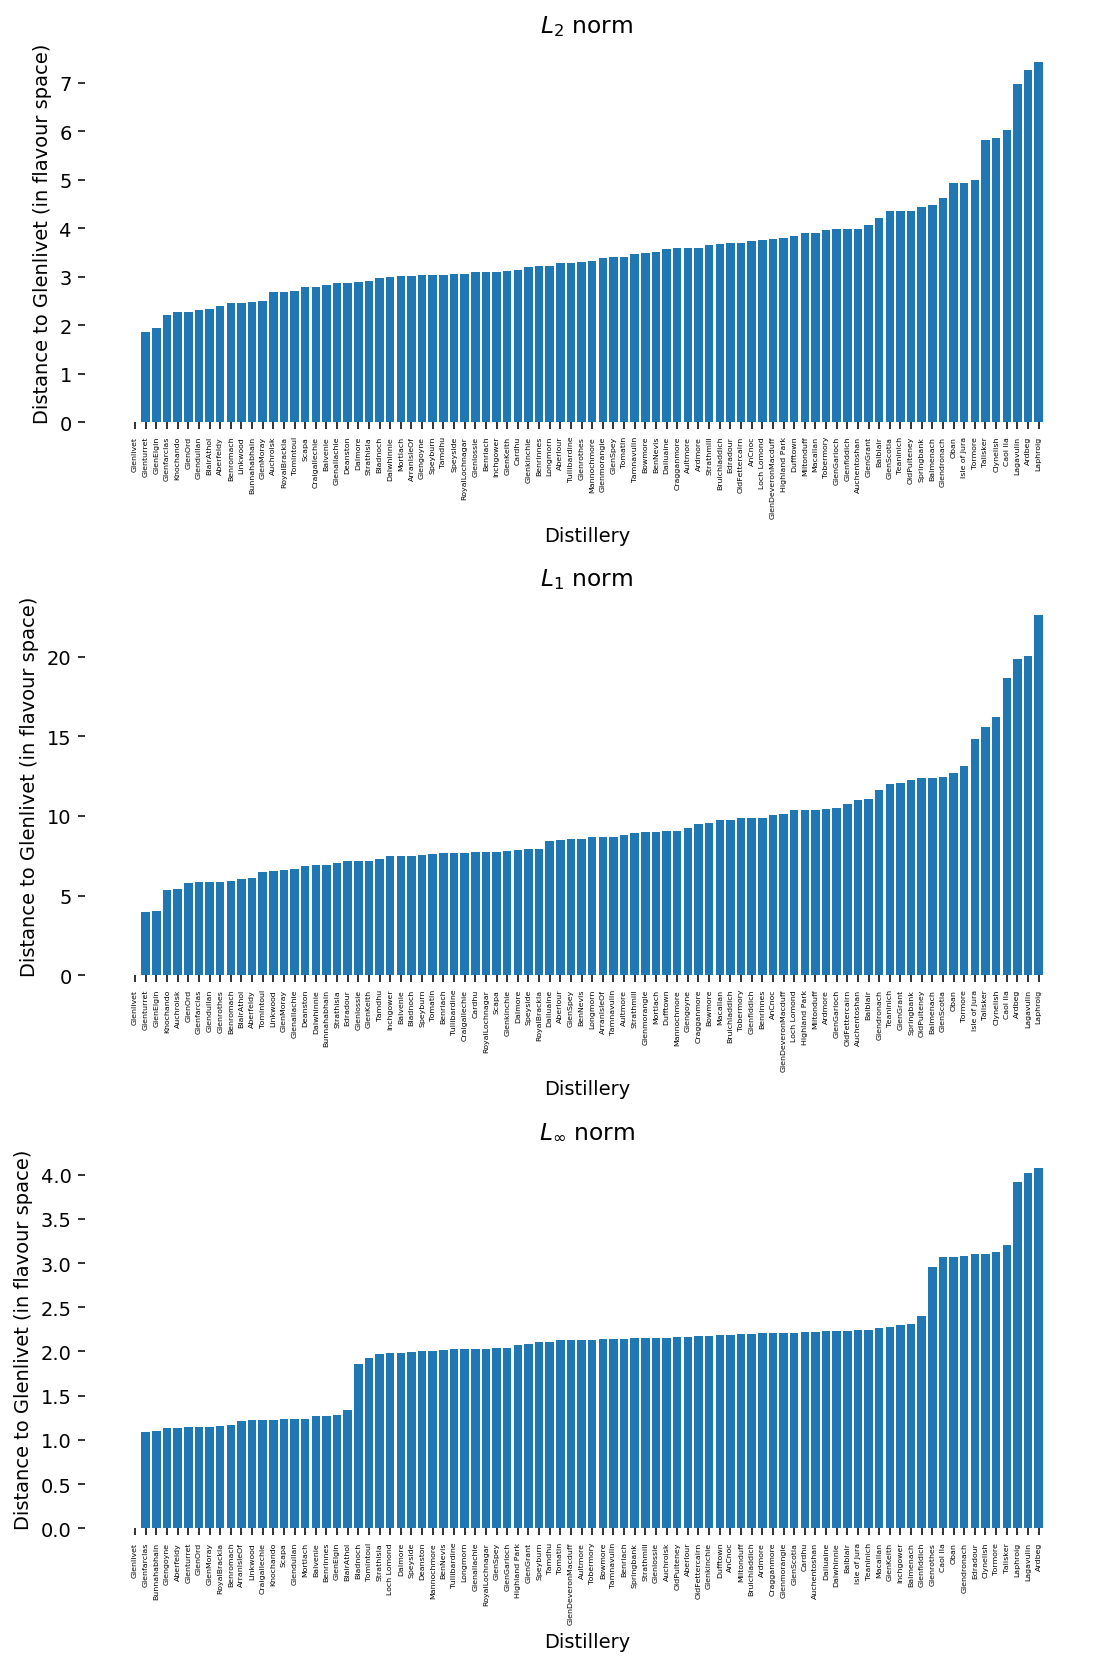

In [117]:
fig = plt.figure(figsize=(8,12))

# you can use this utility function to
# help you get the xticklabels in order
def list_in_order(alist, order):
    """Given a list 'alist' and a list of indices 'order'
    returns the list in the order given by the indices"""
    return [alist[i] for i in order]
    

ax = fig.add_subplot(3,1,1)

def rank_plot(distances):
    # find the ordering of the distances
    order = np.argsort(distances)
    # bar plot them
    ax.bar(np.arange(len(distances)), distances[order])           
    ax.set_xlabel("Distillery")
    ax.set_ylabel("Distance to Glenlivet (in flavour space)")
    ax.set_xticks(np.arange(86))    
    ax.set_frame_on(False)
    # make sure the same order is used for the labels!
    ax.set_xticklabels(list_in_order(distilleries, order),
                       rotation="vertical", fontsize=4)

# make the plots
ax = fig.add_subplot(3,1,1)
ax.set_title("$L_2$ norm")
rank_plot(glenlivet_2)
ax = fig.add_subplot(3,1,2)
ax.set_title("$L_1$ norm")
rank_plot(glenlivet_1)
ax = fig.add_subplot(3,1,3)
ax.set_title("$L_\infty$ norm")
rank_plot(glenlivet_inf)

# removes ugly overlapping
plt.tight_layout()


## Tasks

**Task A.1** 

Compute the $L_2$ norm of each distillery's flavour vector from the flavour vector corresponding to the distillery `Auchentoshan`, and store it in `auchentoshan_2`

In [118]:
auchentoshan_2 = np.linalg.norm(whisky - whisky[distilleries.searchsorted('Auchentoshan')], 2, axis=1)

In [119]:
with tick.marks(2):        
    assert(check_hash(auchentoshan_2, ((86,), 16258.378367770209)))
    

**Task A.2** 
Which distillery is furthest from Auchentoshan's flavour profile in the $L_2$ norm? Store the distillery name in the variable in `unlike_auchentoshan`. Note: compute this -- do not look hardcode it.


In [120]:
unlike_auchentoshan = distilleries[np.argmax(auchentoshan_2)]

In [121]:
with tick.marks(2):        
    assert(case_crc(unlike_auchentoshan)==2291391646)
    print("The distillery most unlike Auchentoshan (L2 norm speaking) is {distillery}.".
          format(distillery=unlike_auchentoshan))


The distillery most unlike Auchentoshan (L2 norm speaking) is Laphroig.


**Note** from now on, use the L2 norm if you need to compute any norms.


### Vector arithmetic
A client says to you:
    
>    I'd like something a bit like Balvenie. But a bit more "lively", the way Cragganmore is more "lively" than Springbank.

Which whisky should you recommend? 

We can work this out:
* What does more "lively" mean? We don't have a "lively" column.
    * But we do have a reference point: Springbank->Cragganmore is somehow "lively"
    * This "direction" between these flavour vectors is *also* a vector
* How do we combine Balvenie's flavour profile with "lively"? We can compose vectors by addition.
* How do we find a distillery that represents this profile? We can compute lengths of vectors using a norm.

**Note: this question is not subjective, nor does it require any trial-and-error or knowledge about whisky. We will answer it directly using vector arithmetic.**



In [122]:
# cache the flavour vectors
cragganmore = whisky[distilleries.searchsorted('Cragganmore')] 
springbank = whisky[distilleries.searchsorted('Springbank')]
balvenie = whisky[distilleries.searchsorted('Balvenie')]

# this is just vector subtraction
lively = cragganmore - springbank

In [123]:
# this is just vector addition
lively_balvenie = balvenie + lively

In [125]:
# find the distances from this flavour profile 
# to all the other whiskies
# this represents a hypothetical distillery
# -- just a point in flavour space
distillery_distances = np.linalg.norm(whisky-lively_balvenie, 
                                      axis=1, ord=2)

# find the index of the nearest real distillery vector to that result
nearest = np.argmin(distillery_distances)

# get the name of the whisky
recommendation = distilleries[nearest]

print("I would recommend {distillery} as more lively version of Balevenie.".format(distillery=
                                                                   recommendation))

I would recommend Benriach as more lively version of Balevenie.


**Task A.3** Find the distillery that best represents (L2 norm) a flavour profile halfway between "Lagavulin" and "Bowmore". Store the name in a variable `halfway_whisky`.

In [126]:
lagavulin = whisky[distilleries.searchsorted('Lagavulin')] 
bowmore = whisky[distilleries.searchsorted('Bowmore')]

half = np.argmin(np.linalg.norm(whisky-((lagavulin+bowmore) * 0.5),
                      axis=1, ord=2))

halfway_whisky = distilleries[half]


In [127]:
assert(case_crc(halfway_whisky)==2804822615)
print("The whisky that best represents a 50:50 mix of Lagavulin and Bowmore is {distillery}".format(distillery=halfway_whisky))

The whisky that best represents a 50:50 mix of Lagavulin and Bowmore is Caol Ila


## Region flavours

We could say that the "representative" element of a collection of vectors was the one closest to the geometric centroid. This is given by the **mean vector** of a data set.

**Task A.4** Compute the mean vector of all of the flavour vectors. Use it to find the names of two distilleries:
* `most_representative` The distillery with the **most** representative flavour profile
* `least_representative` The distillery with the **least** representative flavour profile

In [128]:
mean_vector = np.mean(whisky, axis=0)
most_representative = distilleries[np.argmin(np.linalg.norm(whisky-mean_vector, axis=1, ord=2))]
least_representative = distilleries[np.argmax(np.linalg.norm(whisky-mean_vector, axis=1, ord=2))]

In [129]:
with tick.marks(4):
    assert(case_crc(most_representative)==125187962)
    assert(case_crc(least_representative)==2291391646)
    
print("The most representative whisky distillery is {most}, and the most unusual is {least}".format(most=most_representative,
                                                                                           least=least_representative))

The most representative whisky distillery is Benromach, and the most unusual is Laphroig



### A map
The code below will show a map of Scotland, with the distilleries in their correct positions. Different geographic regions have different characteristic flavour profiles.

One very distinctive region is **Speyside**. This is a region bounded roughly by the box

    263000,860000 -> 343000,785000
    
in the same OS grid units used in the `locations` array. This is highlighted on the map below.


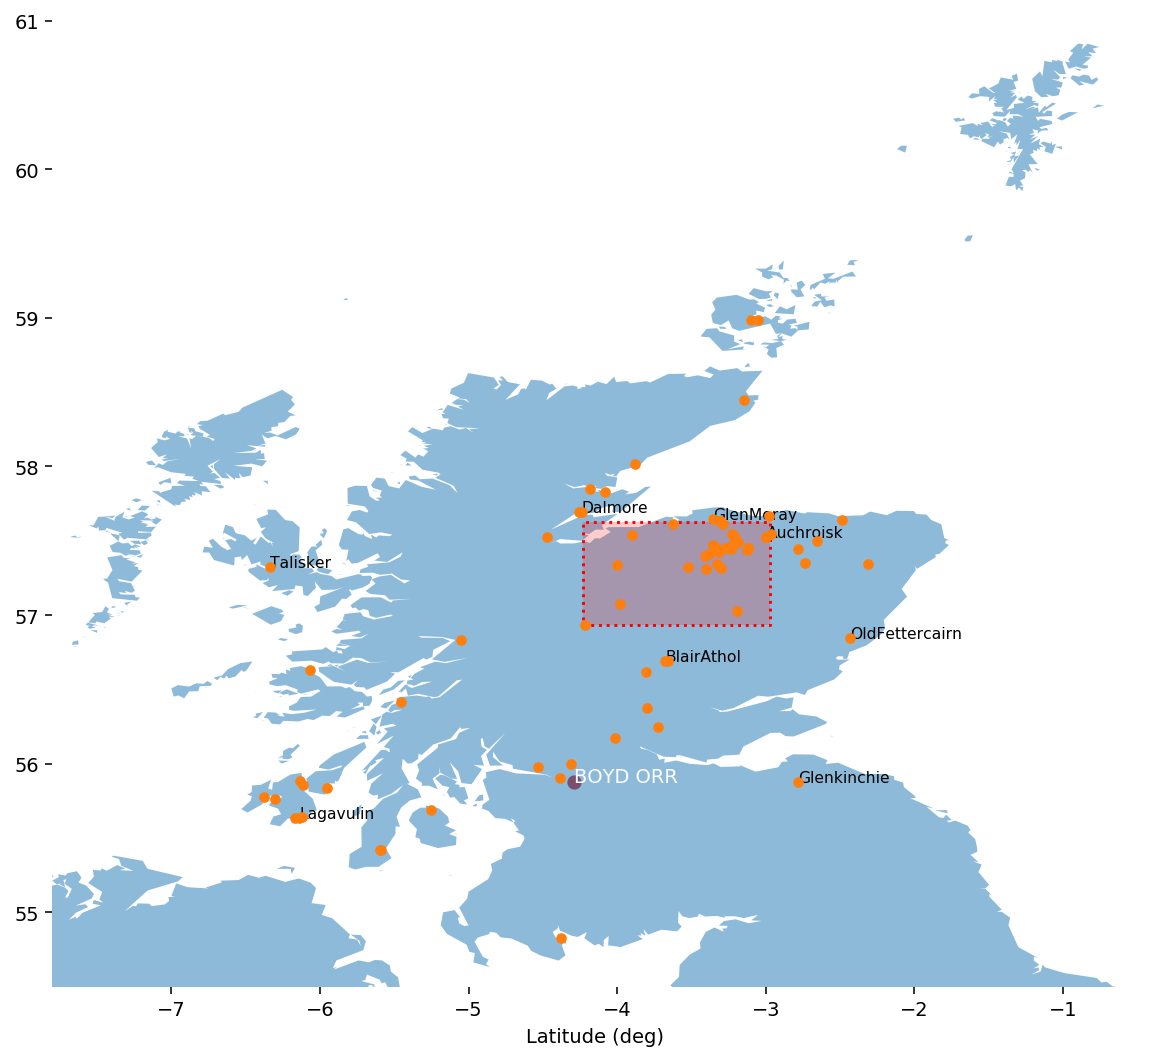

In [130]:
from whisky_map import draw_map, map_box

# draw each distillery label at the locations given.
ax = draw_map(locations, distilleries)

# show the Speyside region
# draw a box in OS grid units
map_box(ax, 263000, 785000, 343000,860000 )

**Task A.5**
* Find all distilleries in Speyside and use this to answer these questions:
* `speyside_flavour`: Compute the most typical whisky flavour profile for Speyside. (i.e. a 12 element vector).
* `most_typical_speyside`: The specific name of the distillery from Speyside that is most typical of that region;
* `least_typical_speyside`: The specific name of the distillery from Speyside that is least typical of that region;
* `most_like_speyside`: The specific name of the distillery from **outside** Speyside that is most similar to a typical Speyside distillery.


**Note:** do not do any of this by hand. Write code.
Hint: Boolean arrays.

In [131]:
## Select the distilleries inside and outside of the Speyside box
## by forming a Boolean array on the locations 
in_speyside = np.logical_and(np.logical_and(locations[:,0]>263600, locations[:,0]<343000), 
               np.logical_and(locations[:,1]>785000, locations[:,1]<860000))

outwith_speyside = np.logical_not(in_speyside)

# compute the mean vector of the Speyside distilleries
speyside_flavour = np.mean(whisky[in_speyside], axis=0)

def sort_distance(matrix, vector):
    return np.argsort(np.linalg.norm(matrix-vector, ord=2, axis=1))

most_typical_speyside = distilleries[in_speyside][sort_distance(whisky[in_speyside], speyside_flavour)[0]]
least_typical_speyside = distilleries[in_speyside][sort_distance(whisky[in_speyside], speyside_flavour)[-1]]
most_like_speyside = distilleries[outwith_speyside][sort_distance(whisky[outwith_speyside], speyside_flavour)[0]]


In [132]:
with tick.marks(2):
    assert(check_hash(speyside_flavour, ((12,), 121.21683682933062)))

In [134]:

with tick.marks(4):
    assert(case_crc(most_typical_speyside)==125187962)
    assert(case_crc(least_typical_speyside)==3190173608)
    assert(case_crc(most_like_speyside)==3551803812)
    
print("The most typical whisky of Speyside is {most}.".format(most=most_typical_speyside))
print("The least typical Speyside whisky of the style is {least}.".format(least=least_typical_speyside))
print("The non-Speyside whisky most like a Speyside whisky is {nonspeyside}.".
      format(nonspeyside=most_like_speyside))               

The most typical whisky of Speyside is Benromach.
The least typical Speyside whisky of the style is Balmenach.
The non-Speyside whisky most like a Speyside whisky is Aberfeldy.


# B: Eigendecompositions and whitening

## Focusing data
<img src="imgs/drop.jpg" width="40%"> <br><br>*[[Image](https://flickr.com/photos/predi/236902022 "just a droplet, but upside down") by [Predi](https://flickr.com/people/predi) shared [CC BY-ND](https://creativecommons.org/licenses/by-nd/2.0/)]*

This part will use  matrix decompositions to form abstract "lenses" that let us see data from different perspectives. This will let us pull out hidden structure and translate among representations.

## Demeaning
The dataset that we have is unnormalised. It is a set of ratings, 0-4, and many of the attributes rated are very correlated (e.g. `smoky` and `medicinal`). Many of the ratings are also on quite different scales, with `tobacco` being much less likely to be rated 4 that `floral`.

It is easier to work with normalised data. 

**Task B.1**
Compute `demeaned_whisky` that has the mean flavour vector removed. 



In [25]:
demeaned_whisky = whisky - mean_vector

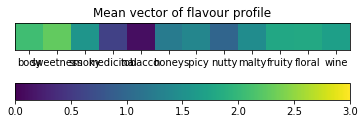

In [26]:
## Show the mean vector as an image strip
## Remember: this represents a point in space
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.imshow(mean_vector[None,:], cmap='viridis', vmin=0, vmax=3)
ax.set_xticklabels(columns)
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks([])
ax.set_title("Mean vector of flavour profile")
fig.colorbar(img, orientation='horizontal')
with tick.marks(2):
    assert(check_hash(demeaned_whisky, ((86, 12), -13044.960552493923)))

* **Task B.2**
Use `np.cov()` to compute the **covariance matrix** of the demeaned data. Call this **whisky_cov**. The code below will show you this as an image. **Note**: this should be a 12x12 matrix!

This tells us how different columns of the dataset are correlated (covary) with each other.

We can see several interesting things:
* having `body` is negatively correlated with being `floral`
* being `smoky` is negatively correlated with having `sweetness`
* `honey` is positively correlated with `wine`

Although the raters have provided 12 different categories, it seems these are not fully independent of each other.


In [135]:
whisky_cov = np.cov(demeaned_whisky.T) # or np.cov(demeaned_whisky, rowvar=False)

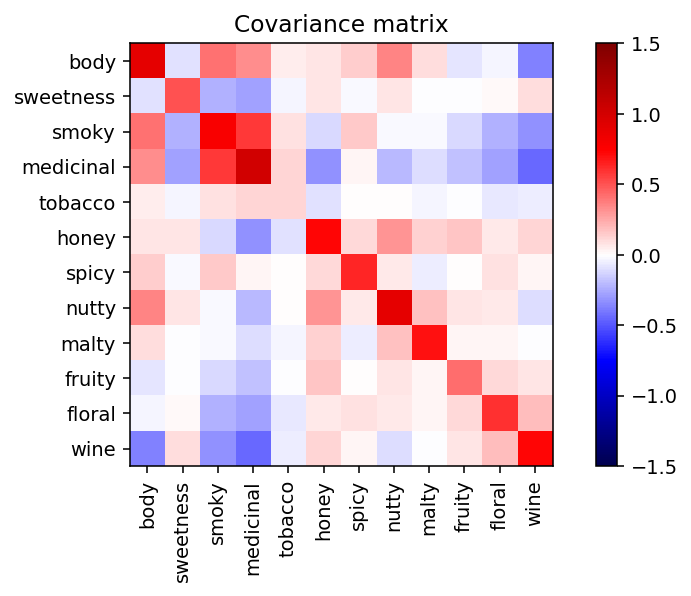

In [136]:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.imshow(whisky_cov, cmap='seismic', vmin=-1.5, vmax=1.5)
ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(12))
ax.set_yticklabels(columns)
ax.set_xticklabels(columns, rotation='vertical')
ax.set_title("Covariance matrix")
fig.colorbar(img)


with tick.marks(2):
    assert(check_hash(whisky_cov, ((12, 12), 611.8479842916136)))
    

## Eigendecomposition of the covariance matrix

We can see the "most important" directions in which the whisky dataset tends to vary. This will be some combination of the various flavour categories. We can analyse this by looking at the covariance matrix in more detail. Recall that the covariance matrix represents an ellipse that "covers" the dataset. The primary axes of this ellipsoidal shape can be found directly from the **eigenvectors** of the covariance matrix. This describes the directions in which the dataset varies. It will let us see truly independent directions of variation.

These are the **principal components** of the dataset. We can compute these directly from the covariance matrix by taking the eigendecomposition. Each eigenvector is a **principal component** and its importance is given by the absolute value of its corresponding eigenvalue, smaller values being "more important".

**Task B.3**
* Compute **all 12** of the principal components of the covariance matrix, in order, *smallest* corresponding (absolute) eigenvalue first. Store this in `whisky_pc`. 
* Store the corresponding principal component lengths in `whisky_pc_len`. The length of a principal component can be computed from the corresponding eigenvalue $\lambda$ as $\frac{1}{\sqrt{\lambda}}$.



In [97]:
evals, evecs = np.linalg.eig(whisky_cov)
order = np.argsort(np.abs(evals))
whisky_pc = evecs[order]
whisky_pc_len = 1.0/np.sqrt(np.abs(evals[order]))

Text(0.5,1,'Component importances')

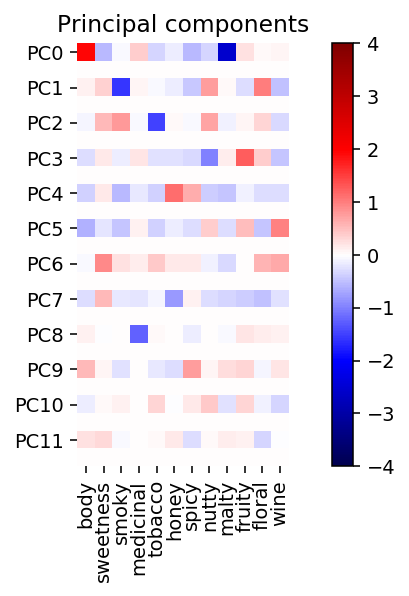

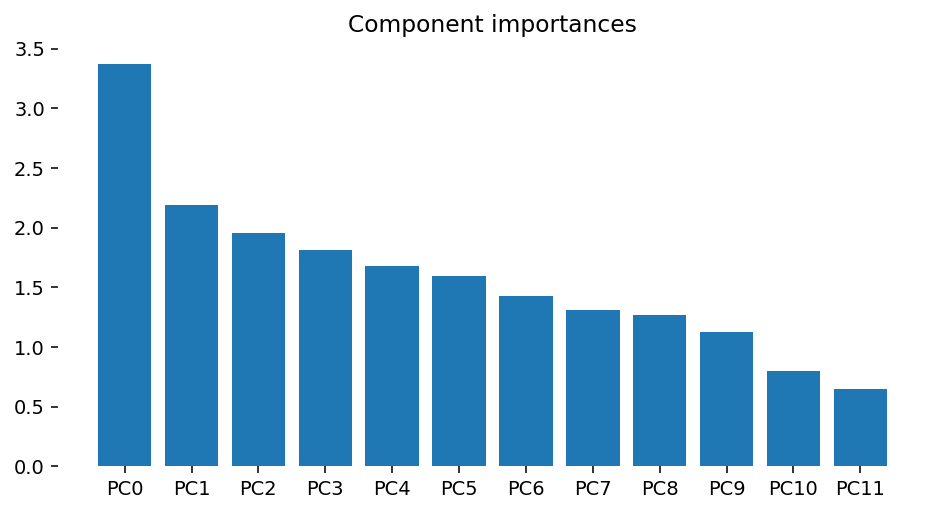

In [138]:
## We can show the principal components as an image
## Each row is a princpal component, and shows a vector
## which represents the direction of variation. The first
## vector represents the largest component, the second
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# space out the principal components, and scale them by the
# length of the components
img = ax.imshow(np.concatenate([(whisky_pc.T*whisky_pc_len).T, 
                                np.zeros_like(whisky_pc)], axis=1).reshape(24,-1), 
                cmap='seismic',         
                vmin=-4, vmax=4)

ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(0,24,2))
ax.set_yticklabels(["PC{i}".format(i=i) for i in np.arange(12)])
ax.set_xticklabels(columns, rotation='vertical')
ax.set_title("Principal components")
ax.set_frame_on(False)
fig.colorbar(img)

## Show the principal component lengths of this dataset
## This shows how much of the variation in the dataset
## is "explained" by the variation along the corresponding direction.
## In this case, we should see that the first component is quite
## large, and looking at the principal components plot above, this
## appears to indicate that there is a spectrum of whiskies
## from "body" types to "malty" types (PC1)
## and from "smoky" types to floral/fruity types (PC2)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(len(whisky_pc_len)), whisky_pc_len)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(["PC{i}".format(i=i) for i in np.arange(12)])
ax.set_frame_on(False)
ax.set_title("Component importances")


In [139]:
with tick.marks(6):
    assert(check_hash(whisky_pc, ((12, 12), 176.61972724966714)))
    assert(check_hash(whisky_pc_len, ((12,), 106.36639712233577)))

## Projecting onto the principal components

This is interesting, but quite hard to interpret. One very useful technique is to project data onto a small number of principal components, to visualise the data. This forms a simplified version of the data, where the use of principal components means we can map the directions in the data which are most important to our visual axes. For example, we might map the first two principal components to a 2D $x,y$ plot.

This is a key technique in exploratory data analysis: **principal component analysis**. All it involves is using the principal components to find a simplified mapping onto a lower-dimensional space.

We can compute a projection of a dataset onto an arbitrary set of vectors by forming a matrix product:
$$P = XV,$$

Where $P$ is an $N\times k$ matrix that is the result of the projection, $X$ is the $N \times D$ original data set and $V$ is an $D \times k$ matrix, each of whose *columns* is a vector that we want to project onto.

**Task B.4**
Use this information to project the distillery data onto the first two principal components, and store the result in `whisky_projected_2d`. If you do this correctly, the plot below should show a 2D mapping of whisky flavours, where more distant distilleries in the map represent more distinct flavour styles.




In [140]:
whisky_projected_2d = whisky @ whisky_pc[0:2, :].T

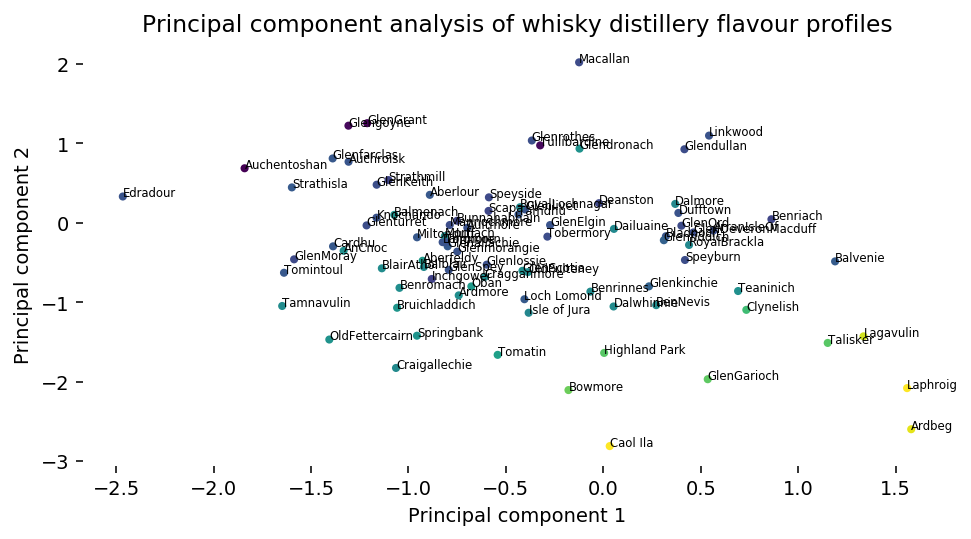

In [143]:
## Show the whisky distilleries laid out
## on the two first principal components
## Colouring the points according to the level of smokiness 
## (just to see that similar whiskies are indeed clustered together)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_frame_on(False)
ax.set_xlabel("Principal component 1")
ax.set_ylabel("Principal component 2")
ax.set_title("Principal component analysis of whisky distillery flavour profiles")
ax.scatter(whisky_projected_2d[:,0], whisky_projected_2d[:,1], c=whisky[:,columns['smoky']], s=10)
for i,name in enumerate(distilleries):
    ax.text(whisky_projected_2d[i,0], whisky_projected_2d[i,1], name, fontdict={'size':6})

In [144]:
with tick.marks(4):
    assert(check_hash(whisky_projected_2d, ((86, 2), -5645.1773024318845)))


**Task B.5** Use the SVD to compute the inverse matrix square root of the matrix $\text{whisky_cov}^{-1/2}$. Multiply the demeaned whisky matrix with this to produce `whitened_whisky`. This represents the data with the mean removed, and all correlations eliminated.

This transforms our dataset so that it is centered on the origin (demeaning) and "spherical" (whitenening with covariance matrix). This is particularly useful if we are going to try and map from data in one vector space to another; having the data in standard scaling, with no offset and no correlation among dimensions makes the data easier to work with.


In [147]:
u,sigma,v = np.linalg.svd(whisky_cov)
inv_sqr = u @ np.diag((1.0/np.sqrt(sigma))) @ v
whitened_whisky =  demeaned_whisky @ inv_sqr


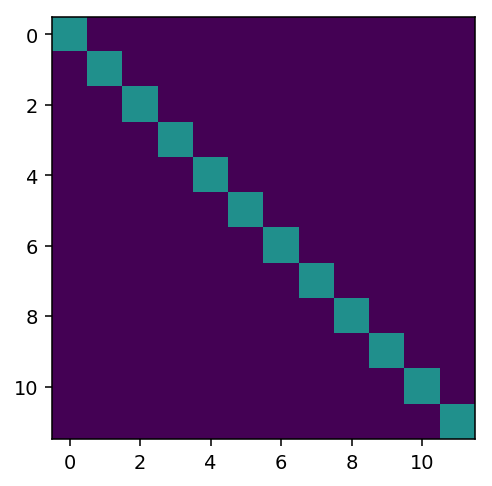

In [148]:
# This plot of the covariance matrix should now be perfectly diagonal
plt.imshow(np.cov(whitened_whisky.T), vmin=0, vmax=2, cmap='viridis')

with tick.marks(4):
    assert(check_hash(whitened_whisky, ((86, 12), -13904.23411235108)))

# C: Linear transforms and machine translation

## 3. Word embeddings
Imagine you have been asked to automate the production of food and drink guides, and use "machine learning" to write descriptions of products instead of employing expensive writers; a virtual [Michael Jackson](https://en.wikipedia.org/wiki/Michael_Jackson_(writer)) (no, not the singer). We want to summarise what the whisky flavour descriptors actually mean. We can use the word embedding to answer vector questions, and **translate the results back into English**.

It'll be a little crude, since a linear transformation is very rigid, and can't capture the nuances of the alignment. However, the results are surprising.

We will use a dataset that maps many English words to high dimensional vectors (50 dimensional). We will then work out how to align our "flavour space" with this "word space" such that we can translate between these spaces.

In [150]:
# load the data
word_data = np.load("data/word_vecs.npz")
word_list = list(word_data["words"])  # the list of words, as strings
word_vectors = word_data["word_vecs"] # the array of word vectors

In [151]:
print(word_list.index("coffee")) # the index of the word
print(word_vectors[word_list.index("coffee")]) # the matching word vector

61502
[ 0.56426    0.4056     0.32018    0.26056    0.41608   -0.10122
 -0.33361   -0.24832    0.12606   -0.48681   -0.16314    0.24174
  0.46633    0.098957  -0.10353    0.12256   -0.92916   -0.26566
  0.52385    0.94311    0.017382   1.5307    -0.60427    0.099082
 -0.18005   -0.21006   -0.78238    0.82745   -0.17398    0.4835
  0.19926   -0.037262  -0.25844    0.14      -0.063149  -0.14532
  0.23837    0.41967    0.66534   -0.54937    0.20695    1.1888
  0.26302   -0.26605    0.40741   -0.20779    0.96839   -0.27695
 -0.20246    0.85282   -0.77621    1.2012    -0.41974   -0.13413
  0.29195   -0.25119    0.068503  -0.20767    0.54443    0.031416
  0.45393   -0.12772   -0.87513    0.010787  -0.23495    0.23648
 -0.37328   -0.2722    -0.19882   -0.022174   0.69154    0.20612
  0.065459  -0.51644    0.3054     0.54596    0.16982   -0.63447
 -1.1564    -0.51715   -0.18109   -1.0373    -0.18963    0.12373
 -0.024359  -0.061753   0.32017   -0.19784    0.51675   -0.28885
 -0.56343    0.1460

We first need to define a sensible way to compare vectors in a very high-dimensional space. The $L_2$ norm has significant problems in very high-dimensional spaces. A more sensible way to compare vectors is to look at the *angle* between them.

**Task C.1**
Define a function `cosine(a,b)` that computes the cosine of the angle between two vectors $a$ and $b$ of the same length (i.e. returns $\cos(\theta)$, a value between -1 and 1).


In [153]:
def cosine(a,b):
    ### BEGIN SOLUTION
 
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    ### END SOLUTION

In [154]:

with tick.marks(4):
    assert(np.allclose(cosine(word_vectors[0], word_vectors[1]), -0.010186264))
    assert(np.allclose(cosine(word_vectors[1], word_vectors[2]), -0.013149176))
    assert(np.allclose(cosine(word_vectors[1000], word_vectors[2000]), -0.16865282))    

We can use this to compare word vectors:

In [155]:
coffee = word_vectors[word_list.index("coffee")]
tea = word_vectors[word_list.index("tea")]
brass = word_vectors[word_list.index("brass")]
justice = word_vectors[word_list.index("justice")]

# coffee is quite like tea, a bit like brass, and not much like justice
print("Coffee -> tea", cosine(coffee, tea))
print("Coffee -> brass", cosine(coffee, brass))
print("Coffee -> justice", cosine(coffee, justice))

Coffee -> tea 0.69417655
Coffee -> brass 0.10266512
Coffee -> justice 0.096824855


## Whitening
We can normalise the word vectors to remove any correlations in it, "dividing out" the covariance matrix. This is a very useful step in preprocessing data. To do this, we need to first demean the data (as we did above), and then we need to remove the correlation among dimensions of the data. 

**Task C.2** Use the SVD to compute the inverse matrix square root of the matrix $\text{word_vectors}^{-1/2}$. Multiply the demeaned word vector matrix with this to produce `whitened_words`. This represents the data with the mean removed, and all correlations eliminated.

This transforms our dataset so that it is centered on the origin (demeaning) and "spherical" (whitenening with covariance matrix). This is particularly useful if we are going to try and map from data in one vector space to another; having the data in standard scaling, with no offset and no correlation among dimensions makes the data easier to work with.

In [171]:
whitened_words = word_vectors - np.mean(word_vectors, axis=0)
word_cov = np.cov(whitened_words, rowvar=False)
u,sigma,v = np.linalg.svd(word_cov)
whitened_words = whitened_words @ (v.T @ (1.0/np.sqrt(sigma)) ** u)

* **Task C.3**

* Create a matrix `flavour_vecs`, which has one row for each of the flavour dimensions of the whisky. Each row of the matrix should be the *whitened* word vector for the corresponding flavour **description** (e.g. the first row will be the whitened word vector corresponding to the string "body").  

       ["body"
       "sweetness"
       "smoky"
       ...
       "wine"]

* Compute the mean vector of this matrix and store it in `mean_flavour_word`
* Find the nearest 8 words to `mean_flavour_word` in terms of angles, and store them in `flavour_descriptors`. Note: your `cosine()` function will not be vectorised. Either use a `for` loop to compare each word in turn, or (harder) vectorise the cosine function.

In [420]:


flavour_vecs = np.array([word_vectors[word_list.index(word)] for word in columns])
mean_flavour_word = np.mean(flavour_vecs, axis=0)


ds = []
for vector in word_vectors:
    d = cosine(vector, mean_flavour_word)
    ds.append(d)
nearest = np.argsort(ds)[-8:]
flavour_descriptors = [word_list[n] for n in nearest]


In [421]:
print(flavour_descriptors)

['flavored', 'taste', 'sweetness', 'spicy', 'aroma', 'flavors', 'fruity', 'flavor']


In [439]:
target = flavour_vecs.T @ (whisky[distilleries.searchsorted('Lagavulin')]/(12*4.0))
ds = []
for vector in word_vectors:
    d = cosine(vector, target)
    ds.append(d)

best = np.argsort(ds)[-20:]    
print([word_list[b] for b in best])

['nutty', 'odor', 'texture', 'aromatic', 'medicinal', 'herbs', 'aromas', 'herbal', 'flavored', 'sweetness', 'spicy', 'pungent', 'fruity', 'smell', 'taste', 'earthy', 'smoky', 'flavors', 'aroma', 'flavor']


We want to be able to take a whisky and describe it in English, by mapping from flavour vector space to word vector space.

    Name -> Flavour vector -> Word vector -> Word name(s)
    
We can see the original whisky matrix as representing a *weighting* of flavours. The original scale is 0.0 -> 3.0.
If we normalise this to range from 0.0 to 1.0, then we can see each rating
    
    

In [384]:
norm_whisky = whisky / (4*12)

name = 'Caol Ila'
word_space =  flavour_vecs.T @ (norm_whisky[distilleries.searchsorted('Benriach')])

ds = []
for vector in norm_words:
    d = cosine(vector, word_space)
    ds.append(d)

best = np.argsort(ds)[-10:]    
print([word_list[b] for b in best])

['rich', 'rice', 'fruits', 'salmon', 'sugar', 'lime', 'salt', 'vinegar', 'fruit', 'juice']


In [344]:
norm_words = whitened_words
norm_whisky = whisky / 3.0
for name in distilleries:
    nearest =  ((flavour_vecs).T) @ ((norm_whisky[distilleries.searchsorted(name)]))
    
    ds = []
    for vector in norm_words:
        d = cosine(vector, nearest)
        ds.append(d)

    best = np.argsort(ds)[-10:]    
    print()
    print(name.center(40))
    for word in best[::-1]:
        print(word_list[word])



               Aberfeldy                
aroma
fruity
sauce
caramel
wine
delicious
honey
sour
cheese
vanilla

                Aberlour                
aroma
sauce
fruity
caramel
honey
delicious
vanilla
sour
lemon
juice

                 AnCnoc                 
aroma
fruity
sauce
caramel
wine
honey
delicious
grape
peach
juice

                 Ardbeg                 
medicinal
flavors
chocolate
aroma
sauce
herbs
creamy
source
powder
naturally

                Ardmore                 
fruity
aroma
sauce
caramel
aromas
syrup
sour
delicious
sweetness
tangy

              ArranIsleOf               
aroma
wine
sauce
herbs
fruity
caramel
grape
delicious
juice
whole

              Auchentoshan              
fruity
wine
aroma
dessert
delicious
grape
sauce
citrus
tasting
juice

               Auchroisk                
aroma
fruity
sauce
caramel
delicious
aromas
sour
vanilla
honey
syrup

                Aultmore                
aroma
fruity
wine
sauce
caramel
syrup
grape
aromas
delicious
tasting

KeyboardInterrupt: 

## Correlation with location
We might want to know what flavour factors is most correlated with geographic location. For example, are smokier whiskies made further West? Does nuttiness change as we go North? We could try and compute the flavours attributes that are *most* related to location. 

One way to do this is to repeat the demean/covariance process, but with a matrix that has the flavour vectors *and* the locations, to form an 86x14 matrix:

         12         2
    | flavours | locations |
    |          |           |
    
The 14x14 covariance of this matrix (after demeaning) will represent the relation between *all* of these variables. 

**Task** Perform this computation. Work out how to find the weighting of attributes that best reflects the change in whisky flavours from East to West (note that locations are in East/West, North/South order).


In [121]:

whisky_aug = np.concatenate([whisky, locations], axis=1)
whisky_aug -= np.mean(whisky_aug, axis=0)
whisky_all_cov = np.cov(whisky_aug.T)
print(whisky_all_cov[:-2,-2])

[-11163.2517718   19987.44762603 -25885.55300047 -44859.36439313
  -1193.25107872  11687.35172763  -1265.44016057  13408.66157609
   2066.67387341  11881.81985739  13042.46486893  13805.29758295]


----
Unit 5 material
---
**Note: you need to have completed Unit 5 of the course to finish this lab**.

### D
The code below shows a map of the UK. You can plot the positions of the distilleries onto this map. However, the map units, which are just raw latitude, longitude and the data in `locations`, which are OS grid references, are not aligned. 

[Read the supplement on homogeneous coordinates before continuing.](week_4_matrices_supplement_homogenous.ipynb)

You will need to create a 3x3 homogeneous transformation matrix to line them up.

You know that the conversion is approximately the following:

* Scale OS Grid X by a factor of 1.57e-5 and add -8.4 to get longitude.
* Scale OS Grid Y by a factor of 0.98e-5 and add 49.3 to get latitude.

No rotation is applied.

Write down a *single transformation matrix* that applies these effects. Call the matrix `transform`.

*[Note: this is definitely not a correct transform from OS Grid Reference to longitude, latitude, but it is approximately correct for visualisation purposes]*


In [81]:
# this one is wrong. fix it.
transform = np.array([[1.0, 0.0, 0.0],
                      [0.0, 1.0, 0.0],
                      [0.0, 0.0, 1.0]])

### BEGIN SOLUTION
transform = np.array([[1.57e-5,  0,         -8.4], 
                      [0,        0.98e-5,   49.3], 
                      [0,        0,         1]])
### END SOLUTION

If your code works, the following code should create a plot where all of the distilleries are (nearly) on land, and in Scotland.

<IPython.core.display.Javascript object>


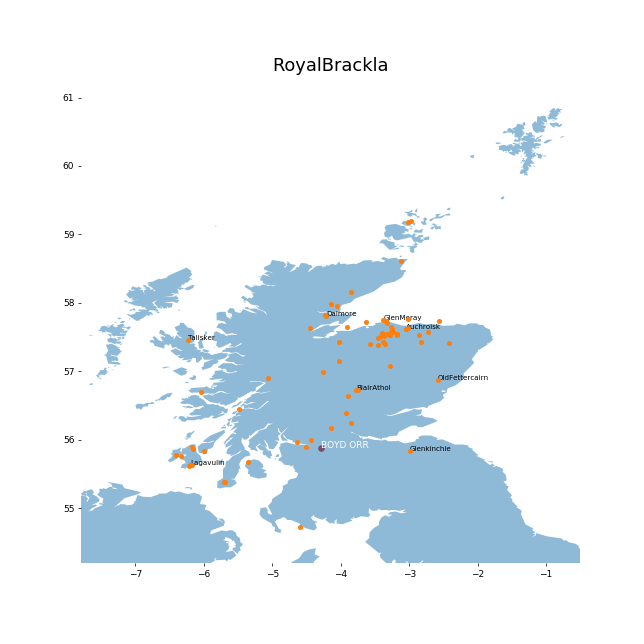

(55.5, 60)

In [84]:
# plot the distillery map

from matplotlib.patches import Polygon

# convert locations to homogenous form [(x,y,1), (x,y,1), ...]
hlocations = np.concatenate([locations, np.ones((len(locations), 1))], axis=1)

# load the coastline data
import pickle
with open("data/gb_coastline_high.dat", "rb") as f:
    coastline = pickle.load(f)

# new figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

# draw the islands
for islands in coastline:
    ax.add_patch(Polygon(np.array(islands), alpha=0.5))

# apply the transformation
transformed = np.dot(hlocations, transform.T)

# draw the distilleries 
ax.scatter(transformed[:, 0], transformed[:, 1], c='C1', zorder=1000, s=20)

# Add a few labels (too many and they would all overlap)
for i in range(7, len(distilleries), 10):
    ax.text(transformed[i, 0], transformed[i, 1], distilleries[i], fontsize=8)

# add key landmarks
ax.text(-4.292649, 55.873571, "BOYD ORR", fontsize=10, color="white")
ax.scatter(-4.292649, 55.873571, s=40, c='C3')

# crop the map to the relevant area
ax.axis("equal")
ax.set_frame_on(False)
ax.set_xlim(-7.8, -0.5)
ax.set_ylim(55.5, 60)

### E. 

Complete the function below, that given a reference distillery name and a norm, will compute:
* the distance to every distillery to the reference distillery, as a vector, using the specified norm.
* the *angle* between each distillery vector and the reference distillery, using the inner product.

Before computing the angle or the norm, **centre** the dataset by subtracting the **mean vector** from the flavour data.

Note that if you have the value $\cos \theta$, you can compute $\theta = \cos^{-1} (\cos \theta)$, using `np.arccos(cos_theta)`.

If you get `nan`s in your calculation, replace them with zero (hint: `np.isnan(x)` will tell you if `x` is NaN).

In [114]:
def whisky_map(distillery, norm):
    """
    Parameters:
        distillery: name of the distillery to compare to
        norm: p-norm to use for distances
    Returns:
        distances: a vector of distances using the given p-norm
        angles: angles between each vector and the given one, in radians
    """
    
    ### BEGIN SOLUTION    
    centered = whisky - np.mean(whisky, axis=0)    
    dis_vector = centered[distilleries.index(distillery)]
    distances = np.linalg.norm(centered-dis_vector, norm, axis=1)
    
    angles = []
    for w in centered:
        # cos theta = a.b / |a||b|
        cos_theta = np.inner(w, dis_vector) / (np.linalg.norm(dis_vector)*np.linalg.norm(w))
        # now we just invert the cosine
        angle = np.arccos(cos_theta)        
        angles.append(angle)
            
    ### END SOLUTION
    return distances, angles
    

In [125]:
with tick.marks(8):
    assert(check_hash(whisky_map('Glengoyne', 1),((2, 86), 49245.55313944925)))
    assert(check_hash(whisky_map('Glengoyne', 2),((2, 86), 29799.205613561873)))
    assert(check_hash(whisky_map('Glengoyne', np.inf), ((2, 86), 24013.88866784305)))
    assert(check_hash(whisky_map('Talisker', 1), ((2, 86), 67849.459195613759)))
    assert(check_hash(whisky_map('Benromach', 2), ((2, 86), 28648.426658992586)))
    assert(check_hash(whisky_map('Glenfiddich', np.inf),((2, 86), 25268.928450118325)))

Using a polar coordinate plot (refer to Unit 3's lecture for details), create a plot with the computed angles and distances from the distillery "Glengoyne" using the L2 norm. Colour each point by its smokiness. 

<IPython.core.display.Javascript object>


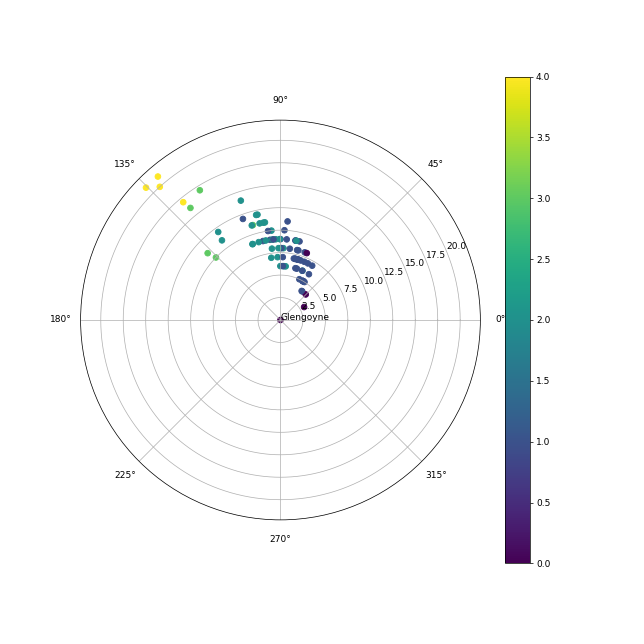

In [128]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection="polar")
#fig, ax, aux = generate_polar_axes()
distances, angles = whisky_map("Glengoyne", 1)    
ax.text(0,0,"Glengoyne")
pts = ax.scatter(angles, np.array(distances), s = 40, c=whisky[:, columns['smoky']])

fig.colorbar(pts)

Your plot should look something like this, but for Glengoyne instead of Talisker.

<img src="imgs/talisker.png">

**Advanced [optional]** You could make this plot interactive, so that clicking on points would show you the label for that point. This is annoying to implement in `matplotlib`, but doable.


<IPython.core.display.Javascript object>


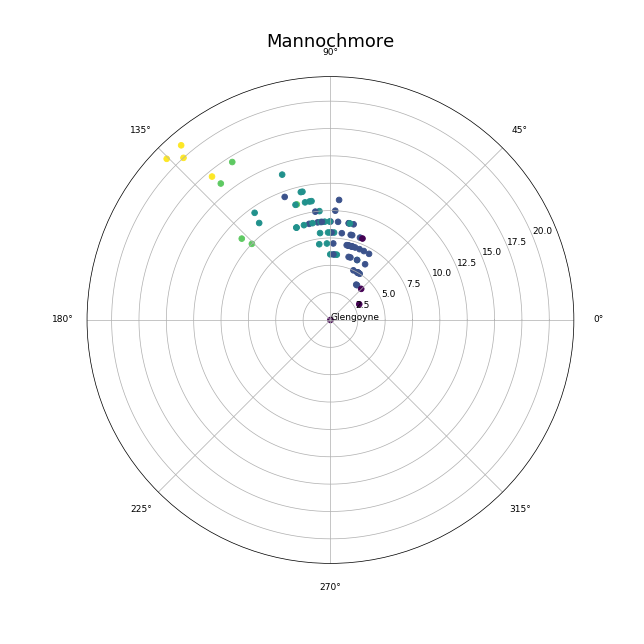

7

In [116]:
## If you want to try making an interactive plot, you can work from this basis
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
### BEGIN SOLUTION
ax = fig.add_subplot(1,1,1, projection="polar")
distances, angles = whisky_map("Glengoyne", 1)

ax.text(0,0,"Glengoyne")
ax.scatter(angles, np.array(distances), s = 40, c=whisky[:, columns['smoky']])

coords = np.stack([angles, distances]).T
def onclick(event):
    x,y = event.xdata, event.ydata
    if x and y:        
        nearest = np.argmin(np.linalg.norm(coords - np.array([x,y]),2,axis=1))
        ax.set_title(distilleries[nearest], fontsize=20)
        
fig.canvas.mpl_connect('button_press_event', onclick)
### END SOLUTION

## C
Plot a scatterplot of the flavour space angle (from the array `whisky`) against the physical angle of each distillery (from the array `locations`), using "Auchentoshan" as the reference distillery. 

Remember: 

Use the L2 norm for both calculations. Is the physical location of distilleries an influence on the flavour of their production?


Text(0.5,1,'Physical distance and flavour distance')

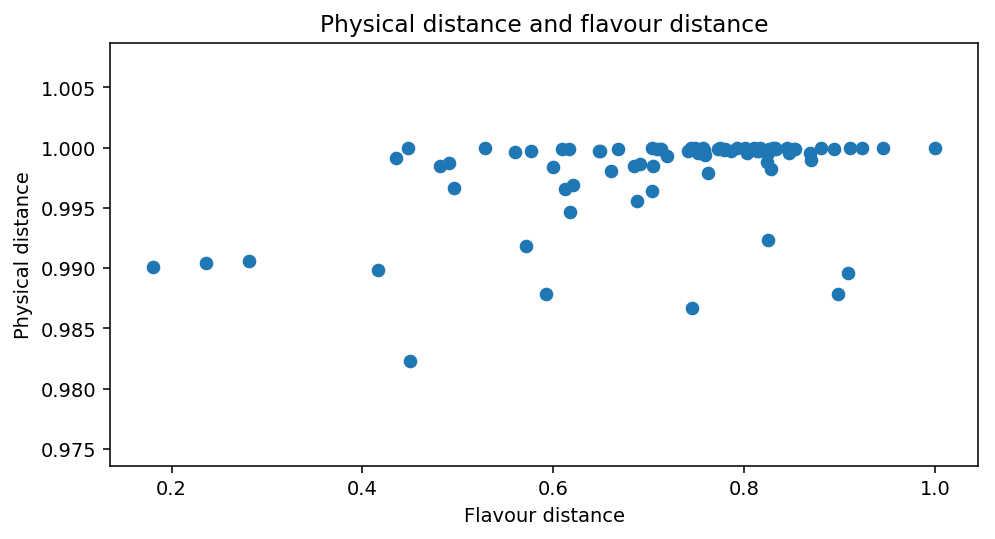

In [221]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

dist = 'Auchentoshan'



flavour_distance = np.dot(whisky, whisky[distilleries.index(dist)])

flavour_distance = flavour_distance / (np.linalg.norm(whisky, axis=1)*
np.linalg.norm(whisky[distilleries.index(dist)]))

physical_distance = np.dot(locations, locations[distilleries.index(dist)])
physical_distance = physical_distance / (
    np.linalg.norm(locations, axis=1)*
np.linalg.norm(locations[distilleries.index(dist)]))

ax.scatter(flavour_distance, physical_distance)

    
ax.set_xlabel("Flavour distance")
ax.set_ylabel("Physical distance")
ax.set_title("Physical distance and flavour distance")



## Whitening

### Interpreting the principal components
We can interpret these vectors directly. For example, it should be apparent that the most important variation in whisky styles (PC 1), is flavours that increase in body as they decrease in maltiness (we could order whiskies in a body->malty spectrum). The second most important variation is flavours where smokiness decreases and floral and nutty flavours increase (we could order whiskies in a smoky->floral spectrum).

**Principal components analysis** allows us to arrange data according to their variation with respect to the principal components. 

**Task** Create a 